# Homework 2
### Sean Morton, ME449

In [1]:
#imports
import core as mr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#variables determined from project description
W1 = 0.109 #changed mm to m
W2 = 0.082
L1 = 0.425
L2 = 0.392
H1 = 0.089
H2 = 0.095

Blist = np.matrix([
    [0,  1, 0, (W1 + W2),          0, (L1 + L2)],
    [0,  0, 1,        H2, -(L1 + L2),         0],
    [0,  0, 1,        H2,        -L2,         0],
    [0,  0, 1,        H2,          0,         0],
    [0, -1, 0,       -W2,          0,         0],
    [0,  0, 1,         0,          0,         0]
]).T

Tsd = [
    [-1, 0, 0, -0.2],
    [0,  0, 1,  0.6],
    [0,  1, 0, 0.35],
    [0,  0, 0,    1]
]

M = np.matrix([
    [-1, 0, 0, (L1 + L2)],
    [ 0, 0, 1, (W1 + W2)],
    [ 0, 1, 0, (H1 - H2)],
    [ 0, 0, 0,         1]
])

eomg = 0.001 #rad
ev = 0.0001 #m

In [3]:
def calculate_V_error(V):
    '''
    - inputs: a twist V
    - outputs: [eomg_curr, elin_curr]
    '''
    w = V[0:3]
    v = V[3:6]
    mag_w = np.linalg.norm(w)
    mag_v = np.linalg.norm(v)
    return np.array([mag_w, mag_v])

#######

V = np.array([2,4,5,6,7,9])
error = calculate_V_error(V)
expected = [np.sqrt(45), np.sqrt(166)]

assert np.allclose(expected, error), f"Observed error: {error}"


In [18]:
def convert_theta_to_xyz(M, Blist, csv_filepath):
    '''
    - write function to convert a series of joint angles into positions 
    in xyz coords of the end effector
        - inputs: M, Blist/Slist, csv_filepath
        - opens and iterates through CSV file
        - uses: FKinBody() or FKinSpace(), inputs M, Blist/Slist, thetalist
        - calculate a transformation matrix that results from 
            the joint angles applied
        - take home configuration of robot and pre- or post-multiply
            transformation from joint angles
        - use [R,p] = TransToRp(T) to get the translation of the end
            effector rel. to. body frame; extract set x,y,z = p
        - outputs a list of lists, [ [x,y,z], [x,y,z], ...) 
        
    Used for plotting the positions of the end effector over time.
    '''
    df = pd.read_csv(csv_filepath, header=None)
    p_list = []
    
    for ind, row in df.iterrows():
        angles = row.tolist()
        
        #apply forward kinematics with given angles; extract xyz and R        
        Jb = mr.JacobianBody(Blist, angles)
        T = mr.FKinBody(M, Blist, angles)
        [_, p] = mr.TransToRp(T)
        p = p.round(3).tolist()
        p_list.append(p)

    
    ####
    return p_list
        
#######

expected = [
    [-0.594, -0.167, -0.162],
    [-0.055,  0.100, -0.364],
    [ 0.033, -0.027,  0.184],
    [ 0.817,  0.191,  0.005],
]

local_csv = "test_hw2_angles.csv"
p_list = convert_theta_to_xyz(M, Blist,local_csv)

#these tolerances make no sense, but I verified by inspection
#that observed elements are close to expected elements within 0.001

#this isn't right - make sure to review in CoppeliaSim and make sure Jacobian
#methods work right

assert np.allclose(expected, p_list, atol = 0.02, rtol = 0.02), \
        f"Observed result: {p_list}"

In [21]:
def write_csv_line(csv_filename, data):
    with open(csv_filename, 'a') as f:
        data_str = ','.join([str(i) for i in data]) + '\n'
        f.write(data_str)
    
####

fname = "CSVwrite_test.csv"
data = [0, 22.45, 0.987, 2262]
write_csv_line(fname, data)

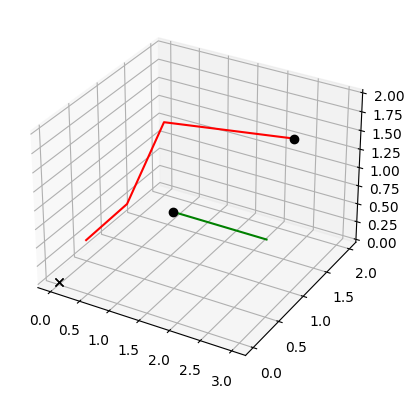

In [22]:
# def xyz_over_time_figure(xyz_list):
def xyz_over_time_figure(ax, xyz_list, target_xyz, color='gray', label=None):

    '''
    - write function to display x, y, z posns over time
        - inputs: xyz_list, a list of lists of xyz coords
        - take in the CSV file for this so we don't have to write 
            code for it that depends on prev. outputs in the Jupyter notebook
        - look up a python library that can do 3D plots you can rotate
        - find out how to do line plots
        - have target_posn be an input; calculate initial_posn from array
            indexing
        - outputs: a figure; display it when ready
    '''
    xdata = [posn[0] for posn in xyz_list]
    ydata = [posn[1] for posn in xyz_list]
    zdata = [posn[2] for posn in xyz_list]
    
    ax.plot(xdata, ydata, zdata, color=color, label=label)
    ax.plot(*target_xyz, color='black', marker='x')
    ax.plot(*xyz_list[0], color='black', marker='o')

    return ax

####

#sample x, y, z
xyz_test = [
    [3, 1, 2],
    [0, 2, 1],
    [0.25, 1, 0.5],
    [0, 0.5, 0.25]
]

xyz_test2 = [
    [1.5, 0.5, 1],
    [3, 0.5, 1]
]

target_xyz = [0, 0, 0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_test, target_xyz, 'red')
ax = xyz_over_time_figure(ax, xyz_test2, target_xyz, 'green')

plt.show()


In [25]:
#try to find the joint vector that IKinBody returns to see if my function is working
theta_list_test = [
    1.646, -0.974, 1.175, 0, 0, 0
] #yields p = [-0.236, 0.588, 0.270]

theta_list_sol, success = mr.IKinBody(Blist, M, Tsd, theta_list_test, eomg, ev)
display(theta_list_sol.round(4).tolist())
display(success)

[1.7417, -1.1987, 1.3008, -0.102, 1.7417, 0.0]

True

In [48]:
#v2: just modify the IKinBody() function

#modified this version of function to only iterate once
def IKinBodyIterates_v2(Blist, M, T, thetalist0, eomg, ev, max_iter):
    """Computes inverse kinematics in the body frame for an open chain robot

    :param Blist: The joint screw axes in the end-effector frame when the
                  manipulator is at the home position, in the format of a
                  matrix with axes as the columns
    :param M: The home configuration of the end-effector
    :param T: The desired end-effector configuration Tsd
    :param thetalist0: An initial guess of joint angles that are close to
                       satisfying Tsd
    :param eomg: A small positive tolerance on the end-effector orientation
                 error. The returned joint angles must give an end-effector
                 orientation error less than eomg
    :param ev: A small positive tolerance on the end-effector linear position
               error. The returned joint angles must give an end-effector
               position error less than ev
    :return thetalist: Joint angles that achieve T within the specified
                       tolerances,
    :return success: A logical value where TRUE means that the function found
                     a solution and FALSE means that it ran through the set
                     number of maximum iterations without finding a solution
                     within the tolerances eomg and ev.
    Uses an iterative Newton-Raphson root-finding method.
    The maximum number of iterations before the algorithm is terminated has
    been hardcoded in as a variable called maxiterations. It is set to 20 at
    the start of the function, but can be changed if needed.

    Example Input:
        Blist = np.array([[0, 0, -1, 2, 0,   0],
                          [0, 0,  0, 0, 1,   0],
                          [0, 0,  1, 0, 0, 0.1]]).T
        M = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
        T = np.array([[0, 1,  0,     -5],
                      [1, 0,  0,      4],
                      [0, 0, -1, 1.6858],
                      [0, 0,  0,      1]])
        thetalist0 = np.array([1.5, 2.5, 3])
        eomg = 0.01
        ev = 0.001
    Output:
        (np.array([1.57073819, 2.999667, 3.14153913]), True)
    """
    thetalist = np.array(thetalist0).copy()
    i = 0
    maxiterations = max_iter
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                      thetalist)), T)))
    err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
          or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    
    joint_vectors = []

    while i < maxiterations: #edited the loop condition so we could print one more time
        
        T_curr = mr.FKinBody(M, Blist, thetalist)
        [mag_w, mag_v] = calculate_V_error(Vb)
        
        print(f"\nIteration {i}:\n")
        print(f"Joint vector: \n{thetalist.round(3).tolist()}\n")    
        print(f"SE(3) end-effector config: \n{T_curr.round(3)}\n")        
        print(f"          error twist V_b: {Vb.round(3).tolist()}")
        print(f"angular error ||omega_b||: {round(mag_w, 4)}")
        print(f"     linear error ||v_b||: {round(mag_v, 4)}")
        
        joint_vectors.append(thetalist)
        
        #------------------#
        if not err: #if error is less than threshold, exit the loop
            break
        
        #-------------------#
        #set up next iteration of loop
        
        thetalist = thetalist \
                    + np.dot(np.linalg.pinv(mr.JacobianBody(Blist, \
                                                         thetalist)), Vb)
        i = i + 1
        Vb \
        = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                       thetalist)), T)))
        
        err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
              or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
        
        
    return (thetalist, not err)

#####

#test with an initial configuration
#thetalist0 = [0,0,0,0,0,0]
thetalist0 = theta_list_test[:] #converges in 3
short_iterates = 5
long_iterates = 20

_,_ = IKinBodyIterates_v2(Blist, M, Tsd, thetalist0, eomg, ev, long_iterates)



Iteration 0:

Joint vector: 
[1.646, -0.974, 1.175, 0.0, 0.0, 0.0]

SE(3) end-effector config: 
[[ 0.074 -0.015 -0.997 -0.236]
 [-0.977  0.199 -0.075  0.588]
 [ 0.2    0.98   0.     0.269]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.165, -1.64, -0.153, -0.029, 0.084, -0.025]
angular error ||omega_b||: 1.6553
     linear error ||v_b||: 0.092

Iteration 1:

Joint vector: 
[1.527, -1.284, 1.413, 0.036, 1.523, -0.117]

SE(3) end-effector config: 
[[-0.994 -0.11  -0.004 -0.088]
 [-0.022  0.162  0.986  0.579]
 [-0.108  0.981 -0.164  0.339]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.164, -0.013, 0.109, 0.112, 0.019, 0.021]
angular error ||omega_b||: 0.1977
     linear error ||v_b||: 0.1151

Iteration 2:

Joint vector: 
[1.757, -1.226, 1.357, -0.133, 1.744, 0.038]

SE(3) end-effector config: 
[[-0.999  0.038 -0.013 -0.207]
 [-0.013 -0.001  1.     0.585]
 [ 0.038  0.999  0.002  0.343]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.002, -

In [49]:
#for a short-iterates test, grab a point close to the desired config of robot
T_close = [
    [-1, 0, 0, -0],
    [0,  0, 1,  0.5],
    [0,  1, 0, 0.2],
    [0,  0, 0,    1]
]

theta_list_test2 = [
    1.310, -1.108, 1.914, 0, 0, 0
] #achieves p = [-0.084, 0.429, 0.121]
#converges in 5

#target p is [-0.2, 0.6, 0.35]
joint_vectors_close = IKinBodyIterates_v2( \
      Blist, M, Tsd, theta_list_test2, eomg, ev, long_iterates)


Iteration 0:

Joint vector: 
[1.31, -1.108, 1.914, 0.0, 0.0, 0.0]

SE(3) end-effector config: 
[[-0.179  0.186 -0.966 -0.083]
 [-0.669  0.697  0.258  0.429]
 [ 0.722  0.692  0.     0.121]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.526, -1.234, -0.685, 0.088, 0.239, 0.177]
angular error ||omega_b||: 1.5064
     linear error ||v_b||: 0.3097

Iteration 1:

Joint vector: 
[0.85, -1.81, 1.913, 0.097, 0.916, -0.078]

SE(3) end-effector config: 
[[-0.997  0.053  0.055  0.101]
 [ 0.063  0.154  0.986  0.356]
 [ 0.044  0.987 -0.157  0.356]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.156, 0.059, -0.049, 0.308, 0.006, 0.235]
angular error ||omega_b||: 0.174
     linear error ||v_b||: 0.3877

Iteration 2:

Joint vector: 
[2.266, -1.523, 1.759, -0.442, 2.232, 0.343]

SE(3) end-effector config: 
[[-0.889  0.457 -0.023 -0.355]
 [-0.094 -0.134  0.987  0.334]
 [ 0.447  0.88   0.162  0.342]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.154, -0.06

In [50]:
theta_list_test3 = [
    1.1, -2.0, 1.4, 0, 0, 0
] #achieves p = [-0.354, 0.314, 0.539]
#converges in 5

#target p is [-0.2, 0.6, 0.35]
joint_vectors_close = IKinBodyIterates_v2( \
      Blist, M, Tsd, theta_list_test3, eomg, ev, long_iterates)


Iteration 0:

Joint vector: 
[1.1, -2.0, 1.4, 0.0, 0.0, 0.0]

SE(3) end-effector config: 
[[-0.374 -0.256 -0.891 -0.079]
 [-0.736 -0.503  0.454  0.265]
 [-0.565  0.825  0.     0.618]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.33, -1.065, 0.538, 0.013, -0.302, 0.334]
angular error ||omega_b||: 1.238
     linear error ||v_b||: 0.4507

Iteration 1:

Joint vector: 
[0.768, -2.14, 2.246, 0.045, 0.791, -0.212]

SE(3) end-effector config: 
[[-0.994 -0.104  0.018  0.031]
 [ 0.006  0.107  0.994  0.262]
 [-0.106  0.989 -0.106  0.303]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.107, 0.012, 0.106, 0.23, 0.077, 0.334]
angular error ||omega_b||: 0.151
     linear error ||v_b||: 0.4128

Iteration 2:

Joint vector: 
[3.528, -1.183, 1.811, -1.029, 3.487, 0.574]

SE(3) end-effector config: 
[[-0.585  0.808 -0.067 -0.441]
 [ 0.068  0.131  0.989 -0.214]
 [ 0.808  0.574 -0.132  0.154]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.154, 0.001, -0.947

In [10]:
#save data to csv so we can access it later.
csv_long = "hw2_data_long.csv"
f = open(csv_long, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_far:
    write_csv_line(csv_long, vec)

csv_short = "hw2_data_short.csv"
f = open(csv_short, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_close:
    write_csv_line(csv_short, vec)

NameError: name 'joint_vectors_far' is not defined

In [11]:
#plot our data
xyz_long = convert_theta_to_xyz(M, Jb,csv_long)
xyz_short = convert_theta_to_xyz(M, Jb,csv_short)
target_xyz = mr.TransToRp(Tsd)[1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_long, target_xyz, 'red', label='long')
ax = xyz_over_time_figure(ax, xyz_short, target_xyz, 'green', label='short')
ax.legend()
plt.show()

NameError: name 'Jb' is not defined